In [1]:
import numpy as np
import sklearn.preprocessing
import torch
from sklearn.model_selection import train_test_split
import torch
from matplotlib import pyplot as plt 
import random
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset, SubsetRandomSampler
import os
import json
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import pandas as pd
from time import time
from torchvision.datasets import ImageFolder
from torch import as_strided


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
PEMS04 = np.load('./高速公路车流量数据集/PEMS04.npz')
dataset_PEMS04 = PEMS04['data']
print(dataset_PEMS04.shape) # 车流量，拥挤程度，车速

(16992, 307, 3)


# 数据处理

In [3]:
%config ServerApp.iopub_data_rate_limit = 10000000

In [4]:
scaler = np.zeros(dataset_PEMS04.shape)
print(scaler.shape)
v_scaler = MinMaxScaler()  # 速度归一化
o_scaler = MinMaxScaler()  # 拥挤程度归一化
f_scaler = MinMaxScaler()  # 车流量归一化
scaler[:,:,0] = f_scaler.fit_transform(dataset_PEMS04[:,:,0])
scaler[:,:,1] = o_scaler.fit_transform(dataset_PEMS04[:,:,1])
scaler[:,:,2] = v_scaler.fit_transform(dataset_PEMS04[:,:,2])
# 划分训练数据集，验证数据集，测试数据集
train_proportion, val_proportion, test_proportion = 0.6, 0.2, 0.2
train_dataset = scaler[:int(train_proportion * len(dataset_PEMS04)),:,:]
val_dataset = scaler[int(train_proportion * len(dataset_PEMS04)):int((train_proportion + val_proportion) * len(dataset_PEMS04)),:,:]
test_dataset = scaler[int((train_proportion + val_proportion) * len(dataset_PEMS04)):,:,:]

(16992, 307, 3)


# 采样

In [5]:
class TrafficDataset(Dataset):
    def __init__(self, dataset, windows_size, predict_len=1):
        self.dataset = dataset
        self.windows_size = windows_size
        self.predict_len = predict_len
        self.T, self.N, self.F = self.dataset.shape  # 时间步，节点数，特征数
        
    def __len__(self):
        return self.T - self.windows_size - self.predict_len + 1
    
    def __getitem__(self, idx):
        # 输入序列: (window_size, N, F)
        x = self.dataset[idx:idx + self.windows_size, :, :]
        
        # 目标序列: (pred_len, N, F) - 预测未来pred_len个时间步
        y = self.dataset[idx + self.windows_size:idx + self.windows_size + self.predict_len, :, :]
        
        # 转换为PyTorch张量并调整维度为 (序列长度, 节点数×特征数)
        # 或者保持原始维度，在模型中处理
        x = torch.FloatTensor(x)  # shape: (window_size, N, F)
        y = torch.FloatTensor(y)  # shape: (pred_len, N, F)
        x = x.reshape(self.windows_size, -1)
        y = y.reshape(self.predict_len, -1)
        return x, y

# 采样

In [6]:
windows_size = 12  # 输入60分钟数据（5分钟×12）
predict_len = 1     # 预测未来5分钟
batch_size = 32
train_ds = TrafficDataset(train_dataset, windows_size, predict_len)
val_ds = TrafficDataset(val_dataset, windows_size, predict_len)
test_ds = TrafficDataset(test_dataset, windows_size, predict_len)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [7]:
for x, y in test_loader:
    print(x.shape)
    break

torch.Size([32, 12, 921])


In [8]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    mae_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(1)
        # 前向计算
        hidden, logits = model(datas)
        logits = logits[-1]
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        mae = torch.mean(torch.abs(labels - logits))
        mae_list.append(mae.item())
        
    return np.mean(loss_list), np.mean(mae_list)


In [9]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [10]:
class MyRnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRnn, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.w_h = nn.Parameter(torch.randn(input_size, self.hidden_size))
        self.u_h = nn.Parameter(torch.randn(self.hidden_size, self.hidden_size))
        self.b_h = nn.Parameter(torch.zeros(self.hidden_size))
        
        self.w_y = nn.Parameter(torch.randn(self.hidden_size, self.output_size))
        self.b_y = nn.Parameter(torch.zeros(self.output_size))
        
        self.tanh = nn.Tanh()
        self.leakyrelu = nn.LeakyReLU()
        
        self.init_weights()
    
    
    def init_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
        
        
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h = torch.zeros(batch_size, self.hidden_size).to(device)
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:,i,:], self.w_h) + torch.matmul(h, self.u_h) + self.b_h)
            y = self.leakyrelu(torch.matmul(h, self.w_y) + self.b_y)
            y_list.append(y)
        
        return h, y_list

In [11]:
# 训练
def training_manual_rnn(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=None,
    eval_step=100,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                labels = labels.squeeze(1)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                hidden, logits = model(datas)

                logits = logits[-1]
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                mae = torch.mean(torch.abs(logits - labels))
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "mae": mae.cpu().item(), "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_mae = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "mae": val_mae, "step": global_step
                    })
                    model.train()

                    if early_stop_callback is not None:
                        early_stop_callback(-val_mae)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [12]:
# 多目标损失函数
def loss_fn(pred, target):
    mae = nn.L1Loss()(pred, target)
    mse = nn.MSELoss()(pred, target)
    return 0.7 * mae + 0.3 * mse  # 平衡误差敏感性

In [13]:
epoch = 30
model_manual_rnn = MyRnn(307 * 3, 128, 307 * 3)
loss_fct_manual_rnn = loss_fn
optimizer_manual_rnn = torch.optim.Adam(model_manual_rnn.parameters(), lr=0.001, weight_decay=1e-4)
early_stop_callback = EarlyStopCallback(patience=5)
model_manual_rnn = model_manual_rnn.to(device)
record_manual_rnn = training_manual_rnn(
    model_manual_rnn,
    train_loader,
    val_loader,
    epoch,
    loss_fct_manual_rnn,
    optimizer_manual_rnn,
    early_stop_callback=early_stop_callback,
    eval_step=500
    )

  0%|          | 0/9570 [00:00<?, ?it/s]

Early stop at epoch 12 / global_step 4000


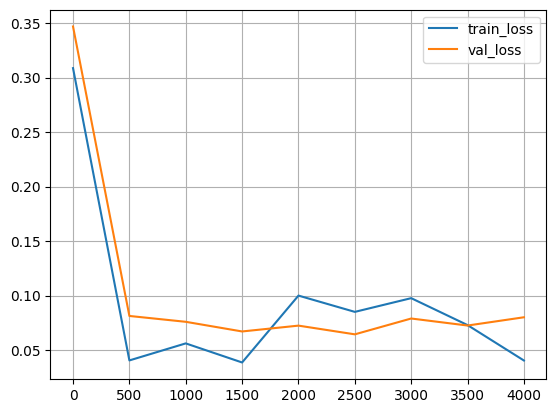

In [14]:
step = [i["step"] for i in record_manual_rnn["train"]]
loss = [i["loss"] for i in record_manual_rnn["train"]]
plt.plot(step[::500], loss[::500], label="train_loss")
plt.plot([i["step"] for i in record_manual_rnn["val"]], [i["loss"] for i in record_manual_rnn["val"]], label="val_loss")
plt.grid()
plt.legend()
# max_loss = max(
#     max([i["loss"] for i in record_manual_rnn["train"]]),
#     max([i["loss"] for i in record_manual_rnn["val"]])
# )
# plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

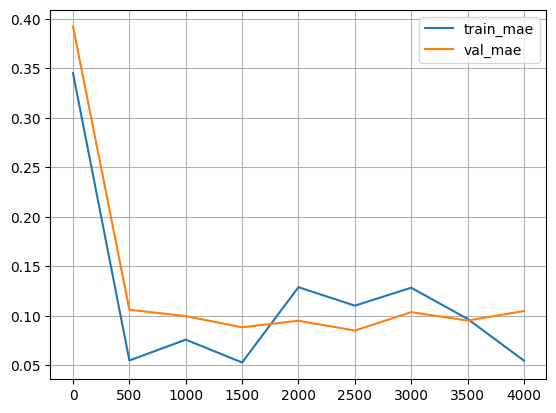

In [17]:
step = [i["step"] for i in record_manual_rnn["train"]]
mae = [i["mae"] for i in record_manual_rnn["train"]]
plt.plot(step[::500], mae[::500], label="train_mae")
plt.plot([i["step"] for i in record_manual_rnn["val"]], [i["mae"] for i in record_manual_rnn["val"]], label="val_mae")
plt.grid()
plt.legend()
# max_acc = max(
#     max([i["acc"] for i in record_manual_rnn["train"]]),
#     max([i["acc"] for i in record_manual_rnn["val"]])
# )
# plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [18]:
model_manual_rnn.eval()
loss, mae= evaluating(model_manual_rnn, test_loader, loss_fct_manual_rnn)
print(f"loss:     {loss:.4f}\nmae: {mae:.4f}")

loss:     0.0799
mae: 0.1048


# torch.nn.rnn

torch.RNN公式和上面的公式略有不同
h既是输入也是输出
$h_t=σ(W_{ih}\times x_t + W_{hh}h_{t−1} + b)$

In [19]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh')
        # self.h0 = nn.Parameter(torch.zeros(batch_size, 1, hidden_size))
        # RNN的输出是hidden_size
        self.y = nn.Linear(hidden_size, output_size)
                
                
    def forward(self, x):
        output, hidden = self.rnn(x)
        hidden = self.y(hidden)
        return  output, hidden

In [20]:
x = torch.randn(32, 12, 307 * 3)
model = RNN(307*3, 256, 307*3)
# output, hidden = model(x)
# hidden = hidden[-1] 
# print(hidden.size())

In [21]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating2(model, dataloader, loss_fct):
    loss_list = []
    mae_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(1)
        # 前向计算
        output, hidden = model(datas)
        hidden = hidden.squeeze(0)
        loss = loss_fct(hidden, labels)         # 验证集损失
        loss_list.append(loss.item())
        mae = torch.mean(torch.abs(labels - hidden))
        mae_list.append(mae.item())
        
    return np.mean(loss_list), np.mean(mae_list)


In [22]:
# 训练
def training_rnn(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=None,
    eval_step=100,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                labels = labels.squeeze(1)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                output, hidden = model(datas)

                hidden = hidden.squeeze(0)
                # 计算损失
                loss = loss_fct(hidden, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                mae = torch.mean(torch.abs(hidden - labels))
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "mae": mae.cpu().item(), "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_mae = evaluating2(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "mae": val_mae, "step": global_step
                    })
                    model.train()

                    if early_stop_callback is not None:
                        early_stop_callback(-val_mae)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [23]:
epoch = 30
model_rnn = RNN(307 * 3, 128, 307 * 3)
loss_fct_rnn = loss_fn
optimizerl_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001, weight_decay=1e-4)
early_stop_callback = EarlyStopCallback(patience=5)
model_rnn = model_rnn.to(device)
record_rnn = training_rnn(
    model_rnn,
    train_loader,
    val_loader,
    epoch,
    loss_fct_rnn,
    optimizerl_rnn,
    early_stop_callback=early_stop_callback,
    eval_step=500
    )

  0%|          | 0/9570 [00:00<?, ?it/s]

Early stop at epoch 12 / global_step 4000


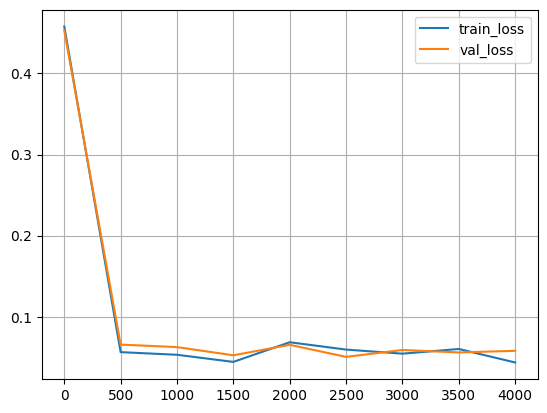

In [24]:
step = [i["step"] for i in record_rnn["train"]]
loss = [i["loss"] for i in record_rnn["train"]]
plt.plot(step[::500], loss[::500], label="train_loss")
plt.plot([i["step"] for i in record_rnn["val"]], [i["loss"] for i in record_rnn["val"]], label="val_loss")
plt.grid()
plt.legend()
# max_loss = max(
#     max([i["loss"] for i in record_manual_rnn["train"]]),
#     max([i["loss"] for i in record_manual_rnn["val"]])
# )
# plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

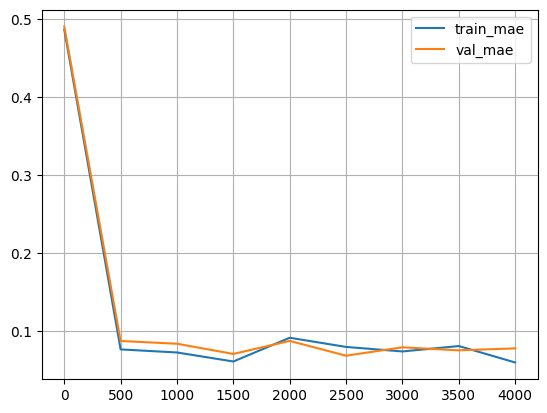

In [25]:
step = [i["step"] for i in record_rnn["train"]]
mae = [i["mae"] for i in record_rnn["train"]]
plt.plot(step[::500], mae[::500], label="train_mae")
plt.plot([i["step"] for i in record_rnn["val"]], [i["mae"] for i in record_rnn["val"]], label="val_mae")
plt.grid()
plt.legend()
# max_acc = max(
#     max([i["acc"] for i in record_manual_rnn["train"]]),
#     max([i["acc"] for i in record_manual_rnn["val"]])
# )
# plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [26]:
model_rnn.eval()
loss, mae= evaluating2(model_rnn, test_loader, loss_fct_rnn)
print(f"loss:     {loss:.4f}\nmae: {mae:.4f}")

loss:     0.0572
mae: 0.0766


# 改变hidden_size

In [27]:
epoch = 30
model_rnn = RNN(307 * 3, 256, 307 * 3)
loss_fct_rnn = loss_fn
optimizerl_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001, weight_decay=1e-4)
early_stop_callback = EarlyStopCallback(patience=5)
model_rnn = model_rnn.to(device)
record_rnn = training_rnn(
    model_rnn,
    train_loader,
    val_loader,
    epoch,
    loss_fct_rnn,
    optimizerl_rnn,
    early_stop_callback=early_stop_callback,
    eval_step=500
    )

  0%|          | 0/9570 [00:00<?, ?it/s]

Early stop at epoch 12 / global_step 4000


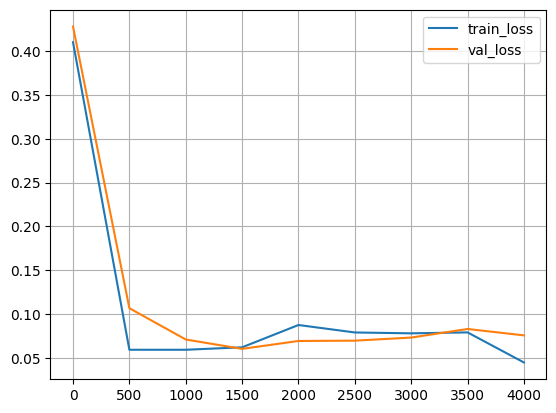

In [28]:
step = [i["step"] for i in record_rnn["train"]]
loss = [i["loss"] for i in record_rnn["train"]]
plt.plot(step[::500], loss[::500], label="train_loss")
plt.plot([i["step"] for i in record_rnn["val"]], [i["loss"] for i in record_rnn["val"]], label="val_loss")
plt.grid()
plt.legend()
# max_loss = max(
#     max([i["loss"] for i in record_manual_rnn["train"]]),
#     max([i["loss"] for i in record_manual_rnn["val"]])
# )
# plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

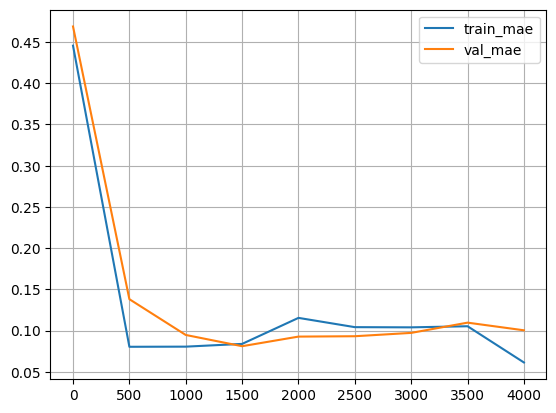

In [29]:
step = [i["step"] for i in record_rnn["train"]]
mae = [i["mae"] for i in record_rnn["train"]]
plt.plot(step[::500], mae[::500], label="train_mae")
plt.plot([i["step"] for i in record_rnn["val"]], [i["mae"] for i in record_rnn["val"]], label="val_mae")
plt.grid()
plt.legend()
# max_acc = max(
#     max([i["acc"] for i in record_manual_rnn["train"]]),
#     max([i["acc"] for i in record_manual_rnn["val"]])
# )
# plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [30]:
model_rnn.eval()
loss, mae= evaluating2(model_rnn, test_loader, loss_fct_rnn)
print(f"loss:     {loss:.4f}\nmae: {mae:.4f}")

loss:     0.0751
mae: 0.0994


# LSTM

In [31]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.y = nn.Linear(hidden_size, output_size)
                
                
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        hidden = self.y(hidden)
        return  output, hidden

In [32]:
# 训练
def training_lstm(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=None,
    eval_step=100,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                labels = labels.squeeze(1)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                output, hidden = model(datas)

                hidden = hidden.squeeze(0)
                # 计算损失
                loss = loss_fct(hidden, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                mae = torch.mean(torch.abs(hidden - labels))
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "mae": mae.cpu().item(), "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_mae = evaluating2(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "mae": val_mae, "step": global_step
                    })
                    model.train()

                    if early_stop_callback is not None:
                        early_stop_callback(-val_mae)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [33]:
epoch = 30
model_lstm = LSTM(307 * 3, 256, 307 * 3)
loss_fct_lstm = loss_fn
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001, weight_decay=1e-4)
early_stop_callback = EarlyStopCallback(patience=5)
model_lstm = model_lstm.to(device)
record_lstm = training_lstm(
    model_lstm,
    train_loader,
    val_loader,
    epoch,
    loss_fct_lstm,
    optimizer_lstm,
    early_stop_callback=early_stop_callback,
    eval_step=500
    )

  0%|          | 0/9570 [00:00<?, ?it/s]

Early stop at epoch 14 / global_step 4500


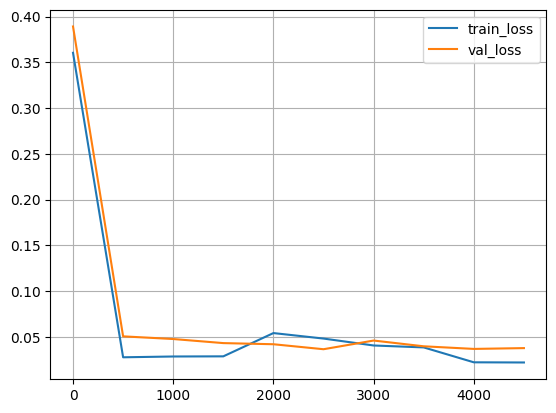

In [35]:
step = [i["step"] for i in record_lstm["train"]]
loss = [i["loss"] for i in record_lstm["train"]]
plt.plot(step[::500], loss[::500], label="train_loss")
plt.plot([i["step"] for i in record_lstm["val"]], [i["loss"] for i in record_lstm["val"]], label="val_loss")
plt.grid()
plt.legend()
# max_loss = max(
#     max([i["loss"] for i in record_manual_rnn["train"]]),
#     max([i["loss"] for i in record_manual_rnn["val"]])
# )
# plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

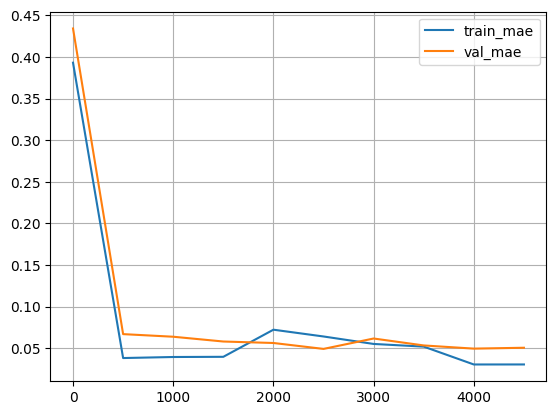

In [36]:
step = [i["step"] for i in record_lstm["train"]]
mae = [i["mae"] for i in record_lstm["train"]]
plt.plot(step[::500], mae[::500], label="train_mae")
plt.plot([i["step"] for i in record_lstm["val"]], [i["mae"] for i in record_lstm["val"]], label="val_mae")
plt.grid()
plt.legend()
# max_acc = max(
#     max([i["acc"] for i in record_manual_rnn["train"]]),
#     max([i["acc"] for i in record_manual_rnn["val"]])
# )
# plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [37]:
model_lstm.eval()
loss, mae = evaluating2(model_lstm, test_loader, loss_fct_rnn)
print(f"loss:     {loss:.4f}\nmae: {mae:.4f}")

loss:     0.0377
mae: 0.0508


# GRU

In [38]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        self.y = nn.Linear(hidden_size, output_size)
                
                
    def forward(self, x):
        output, hidden = self.gru(x)
        hidden = self.y(hidden)
        return  output, hidden

In [39]:
# 训练
def training_gru(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=None,
    eval_step=100,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                labels = labels.squeeze(1)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                output, hidden = model(datas)

                hidden = hidden.squeeze(0)
                # 计算损失
                loss = loss_fct(hidden, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                mae = torch.mean(torch.abs(hidden - labels))
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "mae": mae.cpu().item(), "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_mae = evaluating2(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "mae": val_mae, "step": global_step
                    })
                    model.train()

                    if early_stop_callback is not None:
                        early_stop_callback(-val_mae)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [40]:
epoch = 30
model_gru = GRU(307 * 3, 256, 307 * 3)
loss_fct_gru = loss_fn
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001, weight_decay=1e-4)
early_stop_callback = EarlyStopCallback(patience=5)
model_gru = model_gru.to(device)
record_gru= training_gru(
    model_gru,
    train_loader,
    val_loader,
    epoch,
    loss_fct_gru,
    optimizer_gru,
    early_stop_callback=early_stop_callback,
    eval_step=500
    )

  0%|          | 0/9570 [00:00<?, ?it/s]

Early stop at epoch 10 / global_step 3500


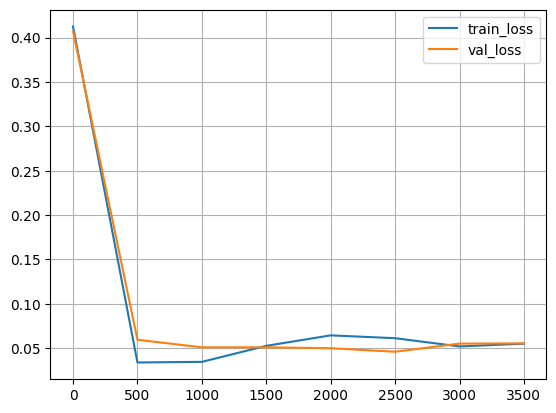

In [41]:
step = [i["step"] for i in record_gru["train"]]
loss = [i["loss"] for i in record_gru["train"]]
plt.plot(step[::500], loss[::500], label="train_loss")
plt.plot([i["step"] for i in record_gru["val"]], [i["loss"] for i in record_gru["val"]], label="val_loss")
plt.grid()
plt.legend()
# max_loss = max(
#     max([i["loss"] for i in record_manual_rnn["train"]]),
#     max([i["loss"] for i in record_manual_rnn["val"]])
# )
# plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

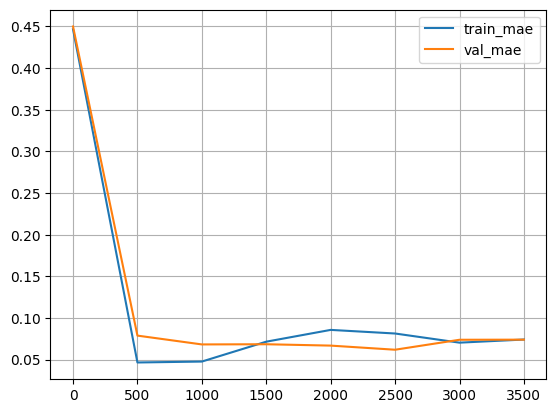

In [42]:
step = [i["step"] for i in record_gru["train"]]
mae = [i["mae"] for i in record_gru["train"]]
plt.plot(step[::500], mae[::500], label="train_mae")
plt.plot([i["step"] for i in record_gru["val"]], [i["mae"] for i in record_gru["val"]], label="val_mae")
plt.grid()
plt.legend()
# max_acc = max(
#     max([i["acc"] for i in record_manual_rnn["train"]]),
#     max([i["acc"] for i in record_manual_rnn["val"]])
# )
# plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [43]:
model_gru.eval()
loss, mae = evaluating2(model_gru, test_loader, loss_fct_gru)
print(f"loss:     {loss:.4f}\nmae: {mae:.4f}")

loss:     0.0554
mae: 0.0740
